<a href="https://colab.research.google.com/github/moharamfatema/face-recognition-pca/blob/main/faces_lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import zipfile
import os
import numpy as np
import cv2
from numpy.linalg import eigh
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
zip_ref = zipfile.ZipFile('/tmp/archive.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp/faces') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
data = np.zeros((400,10304))
label = np.zeros((400,1))

In [ ]:
i = 0
for dir in os.listdir("/tmp/faces"):
  #print(dir)
  if dir == '.ipynb_checkpoints' or dir == "README":
    continue
  folderPath = os.path.join("/tmp/faces",dir)
  # loops 10 times here for each subject
  for individualImage in os.listdir(folderPath):
    # individualImage is 1.pgm for ex
    # imPath is the image path of individualImage
    imPath = os.path.join(folderPath,individualImage)
    image = cv2.imread(imPath,cv2.IMREAD_GRAYSCALE)
    data[i,:] = image.flatten()
    label[i] =  int(dir[1:])
    i+=1

In [ ]:
data_train = np.zeros((200,10304))
label_train = np.zeros((200,1))
data_test = np.zeros((200,10304))
label_test = np.zeros((200,1))
i = 0
k = 0
for j in range(0,400):
  if j%2 == 0:
    data_test[i,:] = data[j,:]
    label_test[i] = label[j]
    i+=1
  else:
    data_train[k,:] = data[j,:]
    label_train[k] = label[j]
    k+=1

In [ ]:
def LDA():
  numberOfClasses = 40
  numberInEachClass = 5
  index = 0
  Zindex = 0
  sumOfEach = np.zeros((40,10304))
  totalSum = np.zeros((1,10304))
  meanOfEach = np.zeros((40,10304))
  totalMean = np.zeros((1,10304))
  Z = np.zeros((200,10304))
  Sb = np.zeros((10304,10304))
  S = np.zeros((10304,10304))
  U = np.zeros((39,10304))
  w = np.zeros((1,39))

  for i in range(1,numberOfClasses+1):
    # gets the indexes of the label with id=i
    place = np.where(label_train[:] == i)
    #print(place[0])
    # sums the 5 pics values in the same id
    for j in range(numberInEachClass):
      #print(data_train[place[0][j],:])
      sumOfEach[index][:] = sumOfEach[index][:] + data_train[place[0][j],:]
      #print("sum here " + str(sumOfEach))
    # getting the mean of each class
    meanOfEach[index][:] = sumOfEach[index][:] / numberInEachClass
    #print("mean here "+ str(meanOfEach[index][:]))

    # getting the centre class matrices Z
    for k in range(numberInEachClass):
      Z[place[0][k],:] = data_train[place[0][k],:] - meanOfEach[index][:]
    #print("printing Z " + str(Z))
    index += 1
  
  totalSum = np.sum(sumOfEach, axis=0)
  #print(totalSum.shape)
  # getting the overall sample mean 
  totalMean = totalSum / numberOfClasses
  #print(totalMean)

  # getting the between class scatter matrix
  for i in range(numberOfClasses):
    difference = meanOfEach[i] - totalMean
    Sb += (numberInEachClass * np.dot(difference, np.transpose(difference)))
  
  # getting the within class scatter matrices S
  #for i in range(numberOfClasses):
  S = np.dot(np.transpose(Z),Z)
  
  w, U = np.linalg.eigh(np.dot(np.linalg.inv(S),Sb))
  sorted_vectors=U[w.argsort()]
  sorted_vectors = np.real(sorted_vectors)
  U=sorted_vectors[-39:]
  print(U.shape)
  return U


In [ ]:
U = LDA()

(39, 10304)


In [ ]:
projectedDataTrain = np.zeros((200,10304))
projectedDataTest = np.zeros((200,10304))
print(U.shape)
projectedDataTrain = np.dot(U,np.transpose(data_train))
projectedDataTest = np.dot(U,np.transpose(data_test))
print("data train projected " + str(projectedDataTrain.shape))
print("data test projected " + str(projectedDataTest.shape))
projectedDataTrain = projectedDataTrain.T
projectedDataTest = projectedDataTest.T

(39, 10304)
data train projected (39, 200)
data test projected (39, 200)


In [ ]:
model=KNeighborsClassifier(n_neighbors=1)
model.fit(projectedDataTrain,label_train)
KNeighborsClassifier(...)
predict=model.predict(projectedDataTest)
score = cross_val_score(model,projectedDataTrain,label_train,cv=5,scoring='accuracy')
print("accuracy for knn:"+str(score.mean()))
print(classification_report(label_test,predict))


(200, 1)
(200, 39)
accuracy for knn:0.805
              precision    recall  f1-score   support

         1.0       1.00      0.20      0.33         5
         2.0       1.00      1.00      1.00         5
         3.0       0.67      0.80      0.73         5
         4.0       0.75      0.60      0.67         5
         5.0       0.62      1.00      0.77         5
         6.0       1.00      1.00      1.00         5
         7.0       1.00      1.00      1.00         5
         8.0       0.83      1.00      0.91         5
         9.0       1.00      0.40      0.57         5
        10.0       1.00      0.80      0.89         5
        11.0       1.00      1.00      1.00         5
        12.0       0.80      0.80      0.80         5
        13.0       0.71      1.00      0.83         5
        14.0       1.00      1.00      1.00         5
        15.0       0.83      1.00      0.91         5
        16.0       0.57      0.80      0.67         5
        17.0       0.62      1.00      

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

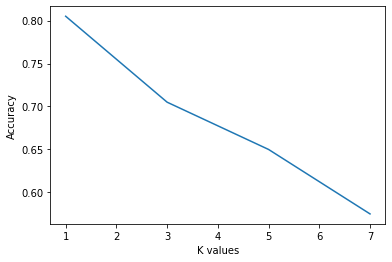

In [ ]:
k_range=range(1,8,2)
k_scores=[]
for k in k_range:
    model=KNeighborsClassifier(n_neighbors=k)
    model.fit(projectedDataTrain,label_train)
    KNeighborsClassifier(...)
    predict=model.predict(projectedDataTest)
    score = cross_val_score(model,projectedDataTrain,label_train,cv=5,scoring='accuracy')
    k_scores.append(score.mean())
plt.plot(k_range,k_scores)
plt.xlabel("K values")
plt.ylabel("Accuracy")
plt.show()